# CX 4230, Spring 2016: [23] Output analysis

You've modeled inputs, built a simulator, and now the simulator is running correctly and producing outputs. Now what?

This notebook accompanies the slides from the Wednesday, March 2 class: [link to T-Square](https://t-square.gatech.edu/access/content/group/gtc-59b8-dc03-5a67-a5f4-88b8e4d5b69a/cx4230-sp16--23-output-analysis.pdf)

Some handy resources for today's notebook:
* Numpy's random number generators: http://docs.scipy.org/doc/numpy/reference/routines.random.html
* Making histograms: http://matplotlib.org/1.2.1/examples/pylab_examples/histogram_demo.html

In [1]:
import numpy as np
from math import sqrt

np.set_printoptions (linewidth=100, precision=2)

In [2]:
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

%matplotlib inline

from ipywidgets import interact

## Central Limit Theorem

Let's start by checking the Central Limit Theorem (CLT) experimentally.

Suppose we have built a simulator that produces a single output value each time it runs. By the argument from class, suppose we may assume that the output of each run $i$ is a random variable $Y_i$, where all $\{Y_i\}$ random variables are independent and identically distributed with some true underlying mean $\mu$ and variance $\sigma^2$.

Here is a hypothetical simulator that obeys these assumptions, at least approximately. In particular, it simply draws output values from an exponential distribution with mean $\mu$, i.e., $Y_i \sim \mathcal{E}(\mu)$. As it happens, the variance of such a distribution is $\sigma^2 = \mu^2$.

In [3]:
MU_TRUE = 1.0

def fake_simulator (mu=MU_TRUE):
    """
    Pretends to simulate some process that produces
    a single output value.
    """
    return np.random.exponential (mu)

VAR_TRUE = MU_TRUE * MU_TRUE

# Demo
fake_simulator ()

0.5337078696525498

The mean of these $n$ runs is another random variable, $\bar{Y}$, where

$$\begin{eqnarray}
  \bar{Y} & \equiv & \dfrac{1}{n} \sum_{i=0}^{n-1} Y_i.
\end{eqnarray}$$

The _Central Limit Theorem_ tells us that the mean will be distributed normally (i.e., as a Gaussian) with mean and variance given by

$$\begin{eqnarray}
  \bar{Y} & \sim & \mathcal{N}\left(\mu, \dfrac{\sigma^2}{\sqrt{n}}\right)
\end{eqnarray}$$

as the number of samples $n \rightarrow \infty$. In other words, the mean of $n$ runs will tend toward the true mean with less and less uncertainty as $n$ increases.

**Exercise.** Complete the following function, which conducts a given number of "experiments," where each experiment is a single run of a given simulator. It returns an array containing the outputs of all these experiments.

In [4]:
def do_experiments (simulator, num_experiments):
    """
    This function repeatedly calls a simulator and records the outputs.
    The simulator must be a function, `simulator()`, that returns a
    single floating-point output value. This function will call the
    simulator `num_experiments` times and return all outputs.
    """
    assert hasattr(simulator, '__call__') # `simulator` must be a function
    Y = np.zeros (num_experiments)
    
    # @YOUSE: Run simulator and record outputs in Y[:]
    for e in range (num_experiments):
        Y[e] = simulator ()
        
    return Y

# Demo
n_e = 10000
Y = do_experiments (fake_simulator, n_e)
print ("n_e =", n_e, "==>", np.mean (Y))

n_e = 10000 ==> 0.98783041206


**Exercise.** Complete the following function, which runs batches of experiments. Each batch consists of running the simulator a given number of times; the number of batches is also given. For each batch, it should record the mean of the simulator runs. It should then return all of those means.

In [5]:
def repeat_experiments (simulator, num_experiments, num_batches):
    """
    This function repeats a batch of simulation experiments many times,
    return the means of each batch.
    
    It uses `do_experiments()` to run one batch of experiments, and
    repeats batch runs `num_batches` times.
    """
    Y_bar = np.zeros (num_batches) # Stores the means of each batch
    
    # @YOUSE: Run batches and record means
    for b in range (num_batches):
        Y_bar[b] = np.mean (do_experiments (simulator, num_experiments))
        
    return Y_bar

# Demo
n_b = 10 # Number of batches
for n_e in [10, 100, 1000]:
    print (n_e, "=>", repeat_experiments (fake_simulator, n_e, n_b))

10 => [ 1.02  0.7   1.08  0.87  0.94  0.68  1.16  1.48  0.83  1.15]
100 => [ 1.07  0.95  1.01  1.04  0.92  1.01  0.91  0.93  0.95  0.98]
1000 => [ 1.    1.04  1.02  0.97  1.02  1.01  1.02  1.01  1.06  0.99]


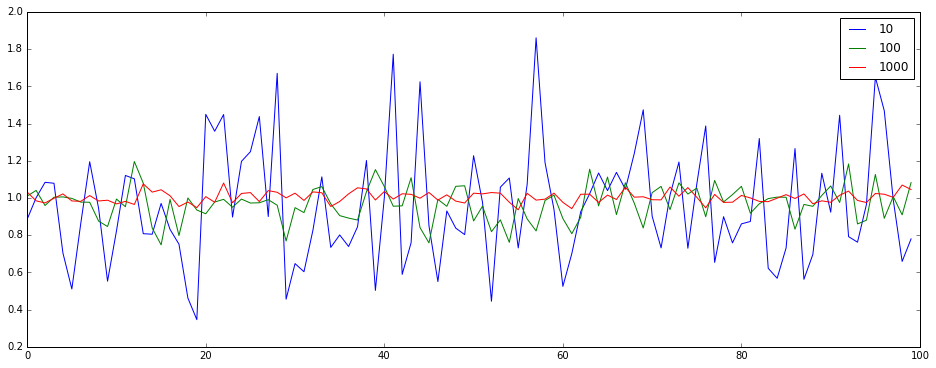

In [6]:
# Another demo, which plots the means of all batches for varying
# numbers of experimental trials per batch.

fig = plt.figure (figsize=(16, 6))
ax = fig.add_subplot (111)

n_b = 100 # Number of batches
for n_e in [10, 100, 1000]:
    x = np.arange (n_b)
    y = repeat_experiments (fake_simulator, n_e, n_b)
    ax.plot (x, y, label=str (n_e))
    
ax.legend ()

**Exercise.** Run the following interactive demo to verify the behavior of the CLT.

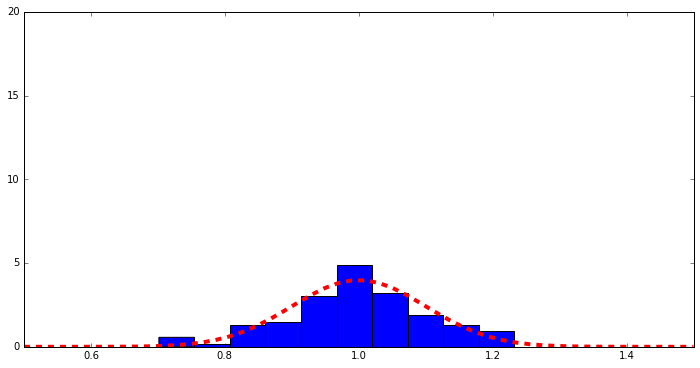

In [7]:
def viz_exp (num_experiments=100, num_repetitions=100):
    """
    Runs many batches of "fake" experiments. Plots a
    histogram and adds a best-fit Gaussian to the plot.
    """
    Y_bar = repeat_experiments (fake_simulator,
                                num_experiments,
                                num_repetitions)
    
    fig = plt.figure (figsize=(12, 6))
    ax = fig.add_subplot (111)
    H, Bins, _ = ax.hist (Y_bar, normed=1)
    plt.xlim ([0.5, 1.5])
    plt.ylim ([0, 20])
    
    # Add best-fit Gaussian
    X_fit = np.linspace (0.5, 1.5)
    Y_fit = mlab.normpdf (X_fit, MU_TRUE, VAR_TRUE/sqrt (num_experiments))
    plt.plot (X_fit, Y_fit, 'r--', linewidth=4)
    
# Demo
x = interact (viz_exp
              , num_experiments=(100, 2000, 100)
              , num_repetitions=(10, 100, 10)
             )

## $t$-test

Suppose you run the simulation $n$ times, observing the output values $y_0$, $y_1$, $\ldots$, $y_{n-1}$. From these observations you then compute the _sample mean_,

$$\begin{eqnarray}
  \bar{y} & \leftarrow & \dfrac{1}{n} \sum_{i=0}^{n-1} y_i.
\end{eqnarray}$$

Since you only have one realization of experiments (i.e., one set of observations), this sample mean is a _point estimate_. How close is this point estimate to the true mean?

Consider the following test statistic, which is sometimes also referred to as the _$t$-statistic_, denoted $t_n$. It is defined in terms of the sample mean ($\bar{y}$) and the _sample variance_, $s_n^2$.

$$\begin{eqnarray}
  s_n^2 & \leftarrow & \dfrac{1}{n} \sum_{i=0}^{n-1} (y_i - \bar{y})^2 \\
  t_n & \equiv & \dfrac{\bar{y} - \mu}{s_n / \sqrt{n-1}}.
\end{eqnarray}$$

Note that $t_n$ is not actually computable in general, as it depends on the _true_ mean, which you don't know. Nevertheless, and quite remarkably, the _distribution_ of $t_n$ _is_ known! In particular, $t_n$ follows [_Student's $t$-distribution_](http://mathworld.wolfram.com/Studentst-Distribution.html), which is parameterized by $n$.

$$\begin{eqnarray}
  t_n & \sim & \mathrm{Student}(n-1).
\end{eqnarray}$$

Moreover, the cumulative distribution function (CDF) of a Student-$t$ random variable is known. Let's call the CDF $F_n(x) \equiv \mathrm{Pr}[t_n \leq x]$. Then, it is possible to compute the probability that $t_n$ falls within some range.

For example, suppose we wish to know the probability that $t_n$ falls between $-x$ and $x$. In terms of the CDF,

$$\begin{eqnarray}
  \mathrm{Pr}[-x \leq t_n \leq x] & = & F_n(x) - F_n(-x).
\end{eqnarray}$$

As it happens, $F_n(x)$ is also symmetric about 0. Therefore, $F_n(x) = 1 - F_n(-x)$ and

$$\begin{eqnarray}
  \mathrm{Pr}[-x \leq t_n \leq x] & = & 2 F_n(x) - 1.
\end{eqnarray}$$

Recall that $t_n$ depends on the true mean, $\mu$, which is unknown. But since the relationship between $t_n$ and $\mu$ _is_ known, you can try to rewrite the probability that $t_n$ falls within some range into an equivalent statement about $\mu$. You would then find,

$$\begin{eqnarray}
  \mathrm{Pr}[-x \leq t_n \leq x]
    & = & \mathrm{Pr}\left[-x \leq \dfrac{\bar{y} - \mu}{s_n / \sqrt{n-1}} \leq x\right] \\
    & = & \mathrm{Pr}\left[\bar{y} - \dfrac{s_n}{\sqrt{n-1}} x \leq \mu \leq \bar{y} + \dfrac{s_n}{\sqrt{n-1}}x \right]
    & = & 2 F_n(x) - 1.
\end{eqnarray}$$

In other words, the true mean, $\mu$, falls within $\pm \dfrac{x s_n}{\sqrt{n-1}}$ of $\bar{y}$ with some probability that can be computed from the CDF.

You can now flip this fact around! That is, you can compute how large a window around $\bar{y}$ you would need to ensure that the probability of the true mean falling in that window is, say, $1 - \alpha$, where you choose $\alpha$ based on your personal tolerance for uncertainty. (A typical value is $\alpha=0.1$.) Then,

$$\begin{eqnarray}
  2 F_n(x) - 1 & = & 1 - \alpha \\
  x & = & F_n^{-1}\left(1 - \dfrac{\alpha}{2}\right).
\end{eqnarray}$$

The interval $\bar{y} \pm \dfrac{F_n^{-1}\left(1 - \dfrac{\alpha}{2}\right) s_n}{\sqrt{n-1}}$ is known as the _$(1 - \alpha)$ confidence interval_. For instance, choosing $\alpha=0.1$ yields a 90% confidence interval.

**Exercise.** Try running 10 simulations and compute the sample mean. Then compute a 95% confidence interval around this sample mean.

> Use the `ppf()` function available in Scipy to invert the CDF: http://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.stats.t.html
>
> The example below computes $F_9^{-1}(0.95)$.

In [8]:
# Example of the inverse CDF

from scipy.stats import t

t.ppf (0.95, 9)

1.8331129326536335

In [10]:
n_e = 10
Y = do_experiments (fake_simulator, n_e)
y_bar = np.mean (Y)
s_n = np.std (Y)

# @YOUSE: Compute a 1-alpha confidence interval, y +/- dy
alpha = 0.05
dy = t.ppf (1-alpha/2, n_e-1) * s_n / (n_e-1)**(0.5)

# Test code
if MU_TRUE < (y_bar-dy) or MU_TRUE > (y_bar + dy):
    err_flag = '**'
else:
    err_flag = ''
print (n_e, "=>", y_bar, "+/-", dy, err_flag)

10 => 0.574765766888 +/- 0.556888659129 


**Exercise.** How many runs (`n_e` above) are needed to get a 95% confidence interval of size +/- 10%?

In [17]:
n_e = 500
for i in range (20):
    Y = do_experiments (fake_simulator, n_e)
    y_bar = np.mean (Y)
    s_n = np.std (Y)

    # @YOUSE: Compute a 1-alpha confidence interval
    alpha = 0.05
    dy = t.ppf (1.0 - 0.5*alpha, n_e-1) * s_n / np.sqrt (n_e-1)
    
    if MU_TRUE < (y_bar-dy) or MU_TRUE > (y_bar + dy):
        err_flag = '**'
    else:
        err_flag = ''

    print (i, ":", y_bar, "+/-", dy, err_flag)

0 : 0.945987110403 +/- 0.0798513053196 
1 : 1.09927499805 +/- 0.0987734692332 **
2 : 0.994628557855 +/- 0.087271375566 
3 : 1.0122648333 +/- 0.0937931960844 
4 : 0.939857312487 +/- 0.0854376635884 
5 : 1.05929857385 +/- 0.0897112822002 
6 : 1.03537075629 +/- 0.0867136058865 
7 : 1.01378503366 +/- 0.0884286505923 
8 : 0.994189713252 +/- 0.0840958978588 
9 : 0.99474980007 +/- 0.0893026896598 
10 : 1.08397042541 +/- 0.0968896180384 
11 : 1.11885566489 +/- 0.0934358771073 **
12 : 1.00155601582 +/- 0.0909897240297 
13 : 0.982333853298 +/- 0.0893321392368 
14 : 0.984744542774 +/- 0.0866467431157 
15 : 0.998608769048 +/- 0.0829960903482 
16 : 1.02083750672 +/- 0.0870662957026 
17 : 1.0758788599 +/- 0.0908190249568 
18 : 0.962445608989 +/- 0.08774685924 
19 : 0.993828532178 +/- 0.0853546807694 
